Prediction of used cars' value from historical data: technical specifications, trim versions, and prices. Recording metrics of:
- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Table of contents

[Imports](#imports)


[1. Data preparation](#1.-Data-preparation)

[Removing incorrect values](#Removing-incorrect-values)
   
[Converting dates to date parts](#Converting-dates-to-date-parts)

[Splitting to sets](#Splitting-to-sets)

[Imputing missing values](#Imputing-missing-values)

[Encoding labels](#Encoding-labels)

[Scaling](#Scaling)


[2. Model training](#2.-Model-training)

[Linear regression for sanity check](#Linear-regression-for-sanity-check)

[Random forest](#Random-forest)

[CatBoost](#CatBoost)

[LightGBM](#LightGBM)


[3. Model analysis](#3.-Model-analysis)

# Imports
<a id='imports'></a>

In [7]:
#Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import Dataset
from sklearn.metrics import mean_squared_error

# 1. Data preparation
<a id='Data preparation'></a>

In [13]:
os.chdir(r'C:\Users\Yael\Documents\yandex')
data = pd.read_csv('car_data.csv')

In [14]:
data_edit = data.copy()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Some features have missing data, some are not numerical and should be dropped or encoded

In [16]:
data.loc[:,['DateCrawled', 'VehicleType', 'Gearbox', 'Model', \
            'FuelType', 'Brand', 'NotRepaired', 'DateCreated', 'LastSeen']].head(10)

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,24/03/2016 11:52,NaN,manual,golf,petrol,volkswagen,NaN,24/03/2016 00:00,07/04/2016 03:16
1,24/03/2016 10:58,coupe,manual,NaN,gasoline,audi,yes,24/03/2016 00:00,07/04/2016 01:46
2,14/03/2016 12:52,suv,auto,grand,gasoline,jeep,NaN,14/03/2016 00:00,05/04/2016 12:47
3,17/03/2016 16:54,small,manual,golf,petrol,volkswagen,no,17/03/2016 00:00,17/03/2016 17:40
4,31/03/2016 17:25,small,manual,fabia,gasoline,skoda,no,31/03/2016 00:00,06/04/2016 10:17
5,04/04/2016 17:36,sedan,manual,3er,petrol,bmw,yes,04/04/2016 00:00,06/04/2016 19:17
6,01/04/2016 20:48,convertible,manual,2_reihe,petrol,peugeot,no,01/04/2016 00:00,05/04/2016 18:18
7,21/03/2016 18:54,sedan,manual,other,petrol,volkswagen,no,21/03/2016 00:00,25/03/2016 16:47
8,04/04/2016 23:42,bus,manual,c_max,petrol,ford,NaN,04/04/2016 00:00,04/04/2016 23:42
9,17/03/2016 10:53,small,manual,golf,NaN,volkswagen,NaN,17/03/2016 00:00,31/03/2016 17:17


In [17]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


RegistrationYear has incorrect values like 1000, 9999

NumberOfPictures is all zeros and can be dropped

Power has extreem outliers

## Removing incorrect values

In [18]:
#dropping NumberOfPictures
data_edit = data_edit.drop('NumberOfPictures', axis=1)

Text(0, 0.5, 'Counts')

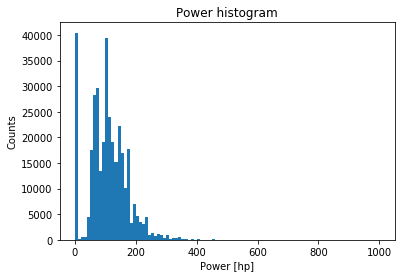

In [19]:
plt.figure;
plt.hist(x= data_edit['Power'], bins=100, range=(0,1000))
plt.title('Power histogram')
plt.xlabel('Power [hp]')
plt.ylabel('Counts')


In [20]:
#setting outliers to nan
data_edit.loc[(data_edit['Power']==0) | (data_edit['Power']>600),'Power'] = np.nan

C:\Users\Yael\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Yael\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Counts')

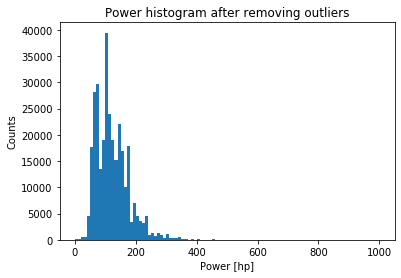

In [21]:
plt.figure;
plt.hist(x= data_edit['Power'], bins=100, range=(0,1000))
plt.title('Power histogram after removing outliers')
plt.xlabel('Power [hp]')
plt.ylabel('Counts')

In [22]:
#setting incorrect RegistrationYear to nan
data_edit.loc[(data_edit['RegistrationYear']<1960) | (data_edit['RegistrationYear']>2020), 'RegistrationYear'] = np.nan

## Converting dates to date parts

In [23]:
#converting dates to datetime
for col in ['DateCrawled','DateCreated','LastSeen']:
    data_edit.loc[:,col] = pd.to_datetime(data_edit.loc[:, col],format='%d/%m/%Y %H:%M')
    for attr in ['year', 'month', 'day','minute']:
            data_edit.loc[:,col+'_'+attr] = getattr(data_edit.loc[:,col].dt, attr)
    data_edit = data_edit.drop(col,axis=1)

In [24]:
data_edit.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,DateCrawled_year,DateCrawled_month,DateCrawled_day,DateCrawled_minute,DateCreated_year,DateCreated_month,DateCreated_day,DateCreated_minute,LastSeen_year,LastSeen_month,LastSeen_day,LastSeen_minute
count,354369.000000,353842.000000,313760.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.0,354369.000000,354369.000000,354369.000000
mean,4416.656776,2003.150092,120.127470,128211.172535,5.714645,50508.689087,2016.0,3.162387,15.852783,46.132196,2015.999924,3.160189,15.859689,0.0,2016.0,3.564987,11.963456,33.267868
std,4514.158514,7.226510,53.892168,37905.341530,3.726421,25783.096248,0.0,0.368806,9.116311,11.044813,0.009046,0.376284,9.123133,0.0,0.0,0.495759,8.886562,14.693983
min,0.000000,1960.000000,1.000000,5000.000000,0.000000,1067.000000,2016.0,3.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.0,2016.0,3.000000,1.000000,0.000000
25%,1050.000000,1999.000000,75.000000,125000.000000,3.000000,30165.000000,2016.0,3.000000,8.000000,40.000000,2016.000000,3.000000,8.000000,0.0,2016.0,3.000000,6.000000,17.000000
50%,2700.000000,2003.000000,110.000000,150000.000000,6.000000,49413.000000,2016.0,3.000000,16.000000,49.000000,2016.000000,3.000000,16.000000,0.0,2016.0,4.000000,7.000000,44.000000
75%,6400.000000,2008.000000,150.000000,150000.000000,9.000000,71083.000000,2016.0,3.000000,24.000000,54.000000,2016.000000,3.000000,24.000000,0.0,2016.0,4.000000,19.000000,46.000000
max,20000.000000,2019.000000,600.000000,150000.000000,12.000000,99998.000000,2016.0,4.000000,31.000000,59.000000,2016.000000,12.000000,31.000000,0.0,2016.0,4.000000,31.000000,59.000000


## Splitting to sets

In [25]:
data_sets = defaultdict(dict)
data_sets['train']['features'], data_sets['test']['features'], data_sets['train']['target'], data_sets['test']['target']\
= train_test_split(data_edit.drop('Price',axis=1), \
                   data_edit['Price'], \
                   test_size=0.25, random_state=12345)

for reviewer:

I did use cross validation so I don't see why I need a validation set (we are supposed to test all models and not choose only one).

linear regression - no parameter tuning

random forest - I used cross_validate on training set

catboost - I used grid_search on training set

lightGBM - I used grid_search_cv


## Imputing missing values

### Imputing missing values in categorical features

In [26]:
obj_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand',  'NotRepaired']
#getting most frequent values of categorical columns
most_freq = data_sets['train']['features'][obj_cols].mode()
most_freq

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,sedan,manual,golf,petrol,volkswagen,no


In [27]:
data_sets['train']['features']['NotRepaired'].value_counts()

no     185347
yes     27053
Name: NotRepaired, dtype: int64

In [28]:
data_sets_imputed = defaultdict(dict)
data_sets_imputed['train']['features'] = data_sets['train']['features'].copy()
data_sets_imputed['test']['features'] = data_sets['test']['features'].copy()
for col in obj_cols:
    data_sets_imputed['train']['features'].loc[:,col] = \
    data_sets_imputed['train']['features'].loc[:,col].fillna(value=most_freq[col][0])
    data_sets_imputed['test']['features'].loc[:,col] = \
    data_sets_imputed['test']['features'].loc[:,col].fillna(value=most_freq[col][0])

In [29]:
data_sets_imputed['train']['features'].isna().sum()

VehicleType               0
RegistrationYear        386
Gearbox                   0
Power                 30459
Model                     0
Mileage                   0
RegistrationMonth         0
FuelType                  0
Brand                     0
NotRepaired               0
PostalCode                0
DateCrawled_year          0
DateCrawled_month         0
DateCrawled_day           0
DateCrawled_minute        0
DateCreated_year          0
DateCreated_month         0
DateCreated_day           0
DateCreated_minute        0
LastSeen_year             0
LastSeen_month            0
LastSeen_day              0
LastSeen_minute           0
dtype: int64

### Imputing missing values in numerical features

In [30]:
#imputing RegistrationYear with mean value
RegistrationYear_mean = data_sets['train']['features']['RegistrationYear'].mean()
data_sets_imputed['train']['features'].loc[:,'RegistrationYear'] = \
data_sets_imputed['train']['features'].loc[:,'RegistrationYear'].fillna(value=RegistrationYear_mean).round()
data_sets_imputed['test']['features'].loc[:,'RegistrationYear'] = \
data_sets_imputed['test']['features'].loc[:,'RegistrationYear'].fillna(value=RegistrationYear_mean).round()

In [31]:
#imputing Power with mean value
Power_mean = data_sets['train']['features']['Power'].mean()
data_sets_imputed['train']['features'].loc[:,'Power'] = \
data_sets_imputed['train']['features'].loc[:,'Power'].fillna(value=Power_mean)
data_sets_imputed['test']['features'].loc[:,'Power'] = \
data_sets_imputed['test']['features'].loc[:,'Power'].fillna(value=Power_mean)

In [32]:
data_sets_imputed['train']['features'].isna().sum()

VehicleType           0
RegistrationYear      0
Gearbox               0
Power                 0
Model                 0
Mileage               0
RegistrationMonth     0
FuelType              0
Brand                 0
NotRepaired           0
PostalCode            0
DateCrawled_year      0
DateCrawled_month     0
DateCrawled_day       0
DateCrawled_minute    0
DateCreated_year      0
DateCreated_month     0
DateCreated_day       0
DateCreated_minute    0
LastSeen_year         0
LastSeen_month        0
LastSeen_day          0
LastSeen_minute       0
dtype: int64

## Encoding labels

In [33]:
data_sets_ohe = defaultdict(dict)
#columns to encode
#saving a copy of original catrgories
obj_set_train = data_sets_imputed['train']['features'][obj_cols].copy()
obj_set_test = data_sets_imputed['test']['features'][obj_cols].copy()
#one hot encoding above columns
data_sets_ohe['train']['features'] = pd.concat([data_sets_imputed['train']['features'].drop(obj_cols, axis=1), \
                                            pd.get_dummies(data_sets_imputed['train']['features'], columns=obj_cols, \
                                                           drop_first=True )], axis=1)
data_sets_ohe['test']['features'] = pd.concat([data_sets_imputed['test']['features'].drop(obj_cols, axis=1), \
                                            pd.get_dummies(data_sets_imputed['test']['features'], columns=obj_cols, \
                                                           drop_first=True)], axis=1)

In [34]:
#checking for columns missing in test set
data_sets_ohe['train']['features'].columns.difference(data_sets_ohe['test']['features'].columns)

Index(['Model_range_rover_evoque', 'Model_samara', 'Model_serie_1',
       'Model_serie_3'],
      dtype='object')

In [35]:
#adding zero columns to test set
data_sets_ohe['test']['features']['Model_range_rover_evoque'] = 0
data_sets_ohe['test']['features']['Model_samara'] = 0
data_sets_ohe['test']['features']['Model_serie_1'] = 0
data_sets_ohe['test']['features']['Model_serie_3'] = 0

## Scaling

In [36]:
#Scaling
scaler = StandardScaler()
scaler.fit(data_sets_ohe['train']['features'])
data_sets_ohe['train']['features'] = scaler.transform(data_sets_ohe['train']['features'])
data_sets_ohe['test']['features'] = scaler.transform(data_sets_ohe['test']['features'])

# 2. Model training

In [37]:
results = {}

## Linear regression for sanity check

In [27]:
LR_model = LinearRegression()
%time LR_model.fit(data_sets_ohe['train']['features'], data_sets['train']['target'])

CPU times: user 17.6 s, sys: 6.47 s, total: 24.1 s
Wall time: 24.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
#Final testing linear regression on test set
%time LR_predictions = LR_model.predict(data_sets_ohe['test']['features'])

CPU times: user 77.7 ms, sys: 7.2 ms, total: 84.8 ms
Wall time: 115 ms


In [29]:
mean_squared_error(data_sets['test']['target'],LR_predictions)**0.5

3843.216211429245

In [30]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [38]:
#saving RMSE, training times and evaluation times to result dictionary for later comparison
results['Linear'] = [3843, 25.1, 8.82, 33.9, 35.8, 75.4, 8.12, 83.6, 34.3]

RMSE for linear regression is 3843, lower than std

## Random forest

In [39]:
#tuning hyper parameters

RF_scores = {}
for n in range(4,11):
    RF_model = RandomForestRegressor(max_depth=3, n_estimators = n, random_state = 12340+n)
    #print(n)
    RF_scores[n] = \
    cross_validate(RF_model, data_sets_ohe['train']['features'], data_sets['train']['target'], \
                   cv=5, scoring=('neg_mean_squared_error'))

In [40]:
for n in range(4,11):
    print('\nn: ', n,'mean RMSE: ', np.mean((abs(RF_scores[n]['test_score']))**0.5), \
          'max RMSE: ', np.max((abs(RF_scores[n]['test_score']))**0.5))


n:  4 mean RMSE:  2991.24371892993 max RMSE:  3006.6537384672356

n:  5 mean RMSE:  3005.944952351704 max RMSE:  3026.9068257755516

n:  6 mean RMSE:  3007.900084291242 max RMSE:  3026.811574803956

n:  7 mean RMSE:  3007.9373287801654 max RMSE:  3026.794655914685

n:  8 mean RMSE:  3005.1000524142873 max RMSE:  3026.8868505452547

n:  9 mean RMSE:  3000.330086657023 max RMSE:  3026.8853889826914

n:  10 mean RMSE:  3004.447794872262 max RMSE:  3021.1050390465507


Smallest RMSE is for n=4 when max_depth=3

### Final testing random forest

In [34]:
# testing on test set
RF_model = RandomForestRegressor(max_depth=3, n_estimators = 4, random_state = 12340+4)
%time RF_model.fit(data_sets_ohe['train']['features'], data_sets['train']['target'])

CPU times: user 6.71 s, sys: 0 ns, total: 6.71 s
Wall time: 7.38 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
                      oob_score=False, random_state=12344, verbose=0,
                      warm_start=False)

In [35]:
%time RF_predictions = RF_model.predict(data_sets_ohe['test']['features'])

CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 121 ms


In [36]:
mean_squared_error(data_sets['test']['target'],RF_predictions)**0.5

3006.1330642102503

In [41]:
#saving RMSE, training times and evaluation times to result dictionary for later comparison
results['RandomForest'] = [3006,7.65, 0, 7.73, 7.76, 115, 0, 115, 124]

Improvement from linear regression.

## CatBoost

In [51]:
#Tuning hyper parameters

CB_model = CatBoostRegressor(logging_level='Silent', cat_features=obj_cols)

#grid tuning hyper parameters
grid = {'learning_rate': [0.03, 0.1, 0.5],
        'depth': [4, 6, 10, 12],
        'iterations': [10, 35, 50],
       'l2_leaf_reg': [2,4]}

grid_search_result = CB_model.grid_search(grid, 
                                       X=data_sets_imputed['train']['features'], 
                                       y=data_sets['train']['target'],
                                          partition_random_seed = 1234,
                                       verbose=False)

In [52]:
#best found parameters
grid_search_result['params']

{'depth': 12, 'l2_leaf_reg': 4, 'iterations': 50, 'learning_rate': 0.5}

In [53]:
CB_model = CatBoostRegressor(cat_features=obj_cols, learning_rate=0.5,depth= 12,
        iterations=50, l2_leaf_reg=4, random_seed=1234)



In [55]:
%time CB_model.fit(X=data_sets_imputed['train']['features'],y=data_sets['train']['target'], logging_level='Silent')

Wall time: 12.5 s


In [56]:
%time CB_predictions = CB_model.predict(data_sets_imputed['test']['features'])

Wall time: 424 ms


In [43]:
mean_squared_error(data_sets['test']['target'],CB_predictions)**0.5

1779.23130912848

In [60]:
#saving RMSE, training times and evaluation times to result dictionary for later comparison
results['CatBoost'] = [1779,30.7, 2.52, 33.2, 34.3, 288, 28.4, 316, 326]

## LightGBM

In [57]:
#preparing categorical features for LGBM
data_sets_lgbm_train = data_sets_imputed['train']['features'].copy()
data_sets_lgbm_test = data_sets_imputed['test']['features'].copy()
for c in obj_cols:
    data_sets_lgbm_train[c] = data_sets_lgbm_train[c].astype('category')
    data_sets_lgbm_test[c] = data_sets_lgbm_test[c].astype('category')
#train_features = Dataset(data_sets_lgbm_train, categorical_feature=obj_cols)
#train_target = Dataset(data_sets['train']['target'])

In [58]:
LGBM_model = LGBMRegressor()
#grid tuning hyper parameters
grid = {'learning_rate': [0.03, 0.1, 0.5],
        'num_leaves': [10, 20, 30, 40],
        'n_estimators': [5, 10, 20, 50],
       'random_state': [1234],
       'objective': ['rmse']}
grid_search_result = GridSearchCV(LGBM_model, grid, scoring='neg_mean_squared_error', n_jobs=-1,cv=3)
grid_search_result.fit(data_sets_lgbm_train,data_sets['train']['target'],feature_name='auto', \
                       categorical_feature=obj_cols)


C:\Users\Yael\Anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1, 0.5],
                         'n_estimators': [5, 10, 20, 50],
                         'num_leaves': [10, 20, 30, 40

In [59]:
grid_search_result.best_params_

{'learning_rate': 0.5,
 'n_estimators': 50,
 'num_leaves': 40,
 'objective': 'rmse',
 'random_state': 1234}

In [48]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [49]:
LGBM_model = LGBMRegressor(learning_rate=0.5,num_leaves=40, n_estimators=50,random_state=1234,objective='rmse')
%time LGBM_model.fit(data_sets_lgbm_train,data_sets['train']['target'],feature_name='auto', \
                       categorical_feature=obj_cols)

CPU times: user 2min 51s, sys: 956 ms, total: 2min 51s
Wall time: 3min 26s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=40, objective='rmse',
              random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [50]:
%time LGBM_predictions = LGBM_model.predict(data_sets_lgbm_test,feature_name='auto',categorical_feature=obj_cols)

CPU times: user 602 ms, sys: 1 ms, total: 603 ms
Wall time: 715 ms


In [51]:
mean_squared_error(data_sets['test']['target'],LGBM_predictions)**0.5

1783.484094949537

In [61]:
#saving RMSE, training times and evaluation times to result dictionary for later comparison
results['LightGBM'] = [1783,7.39, 0.0748, 7.46,7.52, 571, 0, 571, 592]

# 3. Model analysis

In [53]:
index = ['RMSE', 'fit \ CPU \ user [s]', 'fit \ CPU \ sys [s]', 'fit \ CPU \ total [s]', 'fit \ Wall [s]', \
                                    'pred \ CPU \ user [ms]', 'pred \ CPU \ sys [ms]', 'pred \ CPU \ total [ms]', 'pred \ Wall [ms]']
res = pd.DataFrame(results, index=index)

res

,Linear,RandomForest,CatBoost,LightGBM
RMSE,3843.00,3006.00,1779.00,1783.0000
fit \ CPU \ user [s],25.10,7.65,30.70,7.3900
fit \ CPU \ sys [s],8.82,0.00,2.52,0.0748
fit \ CPU \ total [s],33.90,7.73,33.20,7.4600
fit \ Wall [s],35.80,7.76,34.30,7.5200
pred \ CPU \ user [ms],75.40,115.00,288.00,571.0000
pred \ CPU \ sys [ms],8.12,0.00,28.40,0.0000
pred \ CPU \ total [ms],83.60,115.00,316.00,571.0000
pred \ Wall [ms],34.30,124.00,326.00,592.0000


In [54]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Model quality:

- The price mean value is 4416 and std is 4514.

- All RMSE for the models I used are lower than actual std

- RMSE for linear regression and random forest are higher than half the mean, RMSE for catboost and lightGBM are lower

Model speed:

- The user time is the most important metric to evaluate the speed of the code alone, and anyway system times are negligible.

- Training speed: Linear regression and CatBoost take the longest time to train in terms of user CPU time and in terms of actual clock time (wall)

- Prediction speed: Linear regression takes the shortest time to predict in terms of CPU user time and actual clock time

- LightGBM takes the longest time to predict in terms of CPU user time and actual clock time

Conclusions:

- Boosting models have much better results than linear regression and trees in terms of RMSE, but are much slower to predict. 

- Catboost has the lowest RMSE 

- LightGBM has the highest prediction time